<a href="https://colab.research.google.com/github/Manan-Parakh/CBTCIP-/blob/main/Iris_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# General Libraries
import pandas as pd
import numpy as np
import os
import sys
import sklearn

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# To Store the pretty images we create
ROOT = "."
PROJECT_NAME = "IRIS_FLOWER_CLASSIFICATION"
IMAGES_PATH = os.path.join(ROOT, PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(figname, extension = "png", resolution = 300, tight_layout = True):
  path = os.path.join(IMAGES_PATH, figname + '.' + extension)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format = extension, dpi = 300)

# Dataset

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
X = iris.data
y = iris.target

In [4]:
target_names = iris.target_names
feature_names = iris.feature_names
target_names, feature_names

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [5]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
# Let's encode the target values
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
y = encoder.fit_transform(y.reshape(-1,1))
encoder.categories_

[array([0, 1, 2])]

# Exploratory Data Analysis

In [7]:
# Statistical Information
X.columns = feature_names
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
# Exploring the DataTypes and null values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


# Data Visualization

array([[<Axes: title={'center': 'sepal length (cm)'}>,
        <Axes: title={'center': 'sepal width (cm)'}>],
       [<Axes: title={'center': 'petal length (cm)'}>,
        <Axes: title={'center': 'petal width (cm)'}>]], dtype=object)

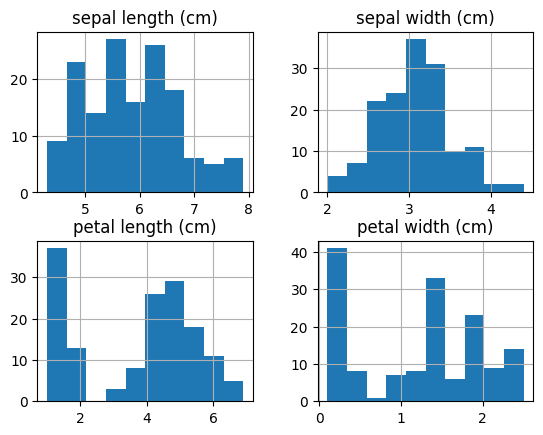

In [100]:
X.hist()

In [101]:
columns = ["sl", "sw", "pl", "pw", "target"]

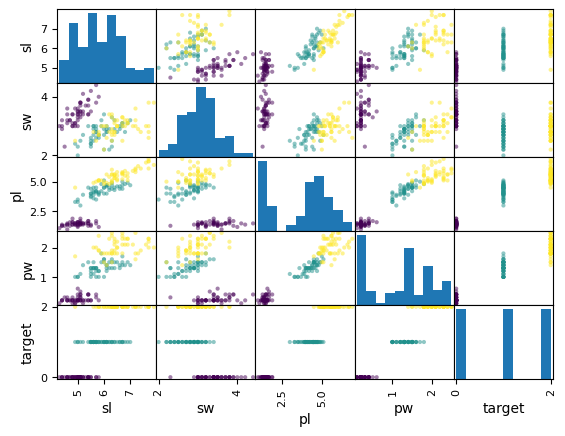

In [102]:
# Scatter_Matrix
from pandas.plotting import scatter_matrix
sm = scatter_matrix(pd.DataFrame(np.c_[X,y], columns = columns), c = y);

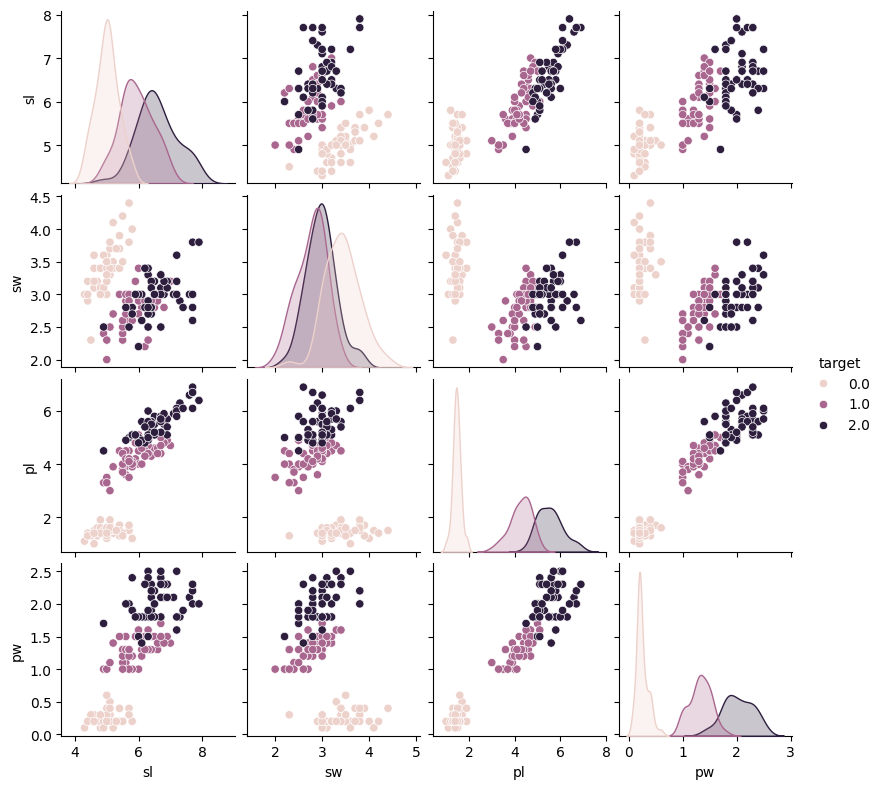

In [205]:
sns.pairplot(pd.DataFrame(np.c_[X,y], columns = columns), hue = 'target', height = 2)

<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

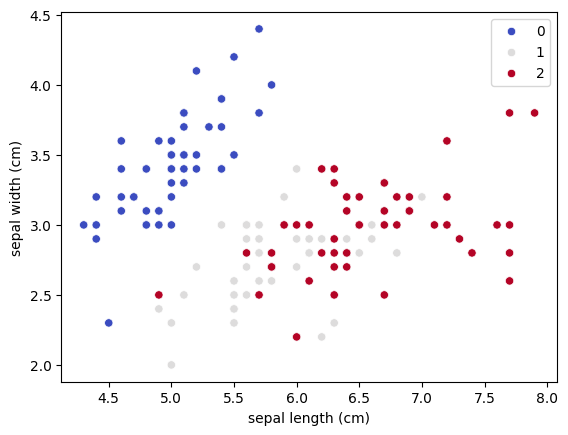

In [206]:
# Let's view a particular chart
sns.scatterplot(x = X['sepal length (cm)'], y = X['sepal width (cm)'], hue = iris.target, palette = "coolwarm")

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

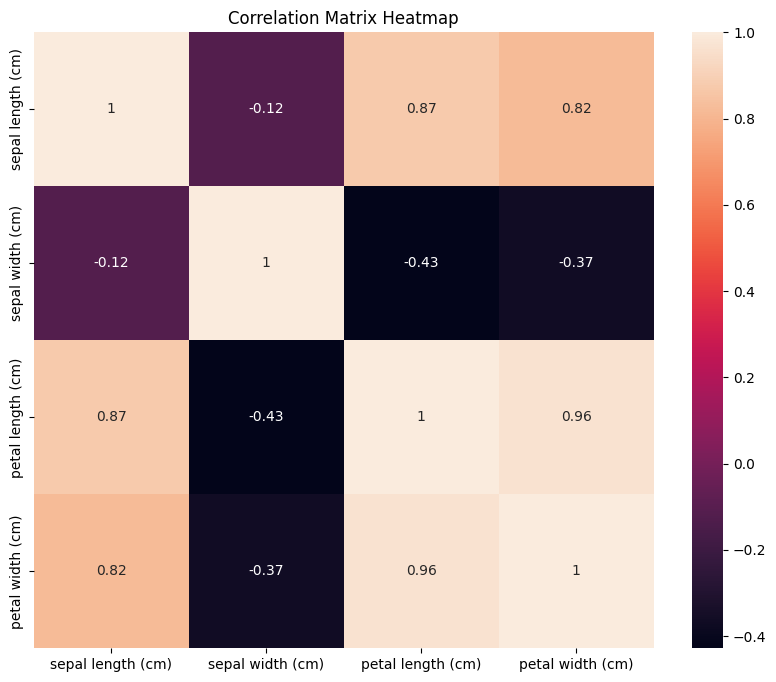

In [204]:
# Correlation Matrix
corr_mat = X.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_mat, annot = True)
plt.title("Correlation Matrix Heatmap")

# Principal Component Analysis

In [207]:
# PCA -> To reduce dimensions
# For tree models, we generally do not need to scale the data. On the other hand, SVM is sensitive to the scale of the data.
# So we will scale the data when required.
# Model -> RFC, ExtraTrees, Boosted -> AdaBoost and GradientBoosting -> Find the best params for all of them and then compare their performances

In [18]:
# Try to reduce dimensions of the dataset
from sklearn.decomposition import PCA
pca = PCA()
# Finding the best number of components to reduce the data to
for comp in range(1,5):
  pca.n_components = comp
  X2 = pca.fit_transform(X)
  print(comp, pca.explained_variance_ratio_, round(sum(pca.explained_variance_ratio_),2))

1 [0.92461872] 0.92
2 [0.92461872 0.05306648] 0.98
3 [0.92461872 0.05306648 0.01710261] 0.99
4 [0.92461872 0.05306648 0.01710261 0.00521218] 1.0


In [19]:
# Choosing n_components to be 2, preserving 98 percent variance but reducing the feature space to just two dimensions.
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

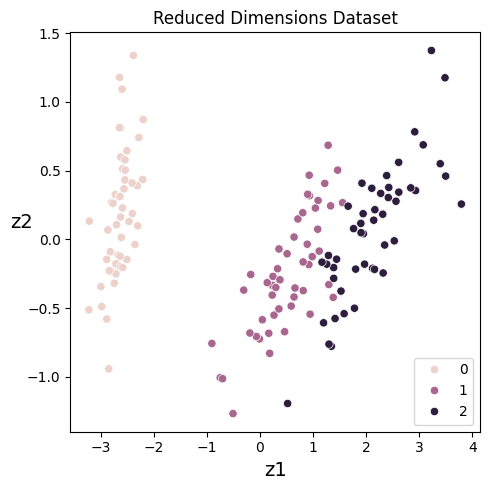

In [20]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = X_reduced[:,0], y =X_reduced[:,1], hue = iris.target)
plt.xlabel("z1", fontsize = 14)
plt.ylabel("z2", fontsize = 14, rotation = 0)
plt.title('Reduced Dimensions Dataset')
save_fig("Reduced_Dimensions_Dataset")

In [146]:
# Split the dataset
# To ensure proper representation of all classes in the test and train set, we use StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(X_reduced,y):
  X_train = X_reduced[train_index]
  X_test = X_reduced[test_index]
  y_train = y[train_index].flatten()
  y_test = y[test_index].flatten()

In [147]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 2), (120,), (30, 2), (30,))

In [23]:
pd.Series(y_train.ravel()).value_counts()/len(y_train)

0.0    0.333333
2.0    0.333333
1.0    0.333333
Name: count, dtype: float64

In [24]:
pd.Series(y_test.ravel()).value_counts()/len(y_test)

0.0    0.333333
2.0    0.333333
1.0    0.333333
Name: count, dtype: float64

In [104]:
# After a lot of runs, it is getting hectic to calculate various metrics again and again,
# Lets create a function
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

def model_perf(model, X_tr, y_tr, X_te, y_te):
  """ Take the model,
  1. Fit the training data,
  2. Get the metrics on trained data and test data
  3. Metrics to get -> Accuracy, Precision, Recall and F1_score, Plot the Confusion Matrix, AUC and ROC curve
  """
  model.fit(X_tr, y_tr)
  y_pred_tr = model.predict(X_tr)
  y_pred_te = model.predict(X_te)

  # Accuracy
  accuracy_tr = accuracy_score(y_tr, y_pred_tr)
  accuracy_te = accuracy_score(y_te, y_pred_te)
  print("Accuracy Score on Training Set:", accuracy_tr)
  print("Accuracy Score on Testing Set:", accuracy_te)

  # Classification_report
  cr_tr = pd.DataFrame(classification_report(y_tr, y_pred_tr, output_dict = True)).T
  cr_te = pd.DataFrame(classification_report(y_te, y_pred_te, output_dict = True)).T

  print('Train Report')
  print(cr_tr)
  print('Test Report')
  print(cr_tr)

  # Plot the Heatmaps of Confusion matrix
  conf_mat_tr = confusion_matrix(y_tr, y_pred_tr)
  conf_mat_te = confusion_matrix(y_te, y_pred_te)
  fig, axes = plt.subplots(1,2, figsize = (10,5))
  sns.heatmap(conf_mat_tr, ax = axes[0], annot = True)
  sns.heatmap(conf_mat_te, ax = axes[1], annot = True)
  axes[0].set_title('Train Set')
  axes[1].set_title('Test Set')
  axes[0].set_xlabel('Predicted Class')
  axes[0].set_ylabel('Actual Class')
  axes[1].set_xlabel('Predicted Class')

# Random Forest Classifier

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [111]:
import pickle
with open("/content/drive/MyDrive/CipherByte/IRIS/rnd_clf.pkl", mode = 'rb') as file:
  rnd_clf = pickle.load(file)

In [96]:
# Training a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier()

In [95]:
# We will use GridSearchCV to figure out the best possible parameters for our RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameter_grid = {"n_estimators": np.arange(5,30,5),
                  "criterion": ['gini', 'entropy'],
                  "max_depth": range(1,4),
                  "min_samples_split": range(2,10)}
grid = GridSearchCV(rnd_clf, parameter_grid, cv = 3)
grid.fit(X_train, y_train)
grid.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 15}

In [97]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 15}

In [98]:
rnd_clf = grid.best_estimator_

Accuracy Score on Training Set: 0.9583333333333334
Accuracy Score on Testing Set: 0.9
Train Report
              precision    recall  f1-score     support
0.0            1.000000  1.000000  1.000000   40.000000
1.0            0.926829  0.950000  0.938272   40.000000
2.0            0.948718  0.925000  0.936709   40.000000
accuracy       0.958333  0.958333  0.958333    0.958333
macro avg      0.958516  0.958333  0.958327  120.000000
weighted avg   0.958516  0.958333  0.958327  120.000000
Test Report
              precision    recall  f1-score     support
0.0            1.000000  1.000000  1.000000   40.000000
1.0            0.926829  0.950000  0.938272   40.000000
2.0            0.948718  0.925000  0.936709   40.000000
accuracy       0.958333  0.958333  0.958333    0.958333
macro avg      0.958516  0.958333  0.958327  120.000000
weighted avg   0.958516  0.958333  0.958327  120.000000


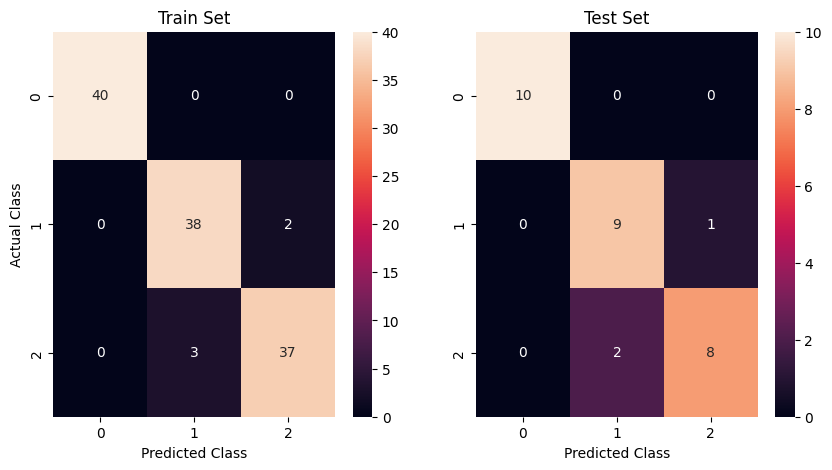

In [148]:
model_perf(rnd_clf, X_train, y_train, X_test, y_test)

In [132]:
# Let's save the model so that we don't have to train it again and again
import pickle
with open("/content/drive/MyDrive/CipherByte/IRIS/rnd_clf.pkl", mode = 'wb') as file:
  pickle.dump(rnd_clf, file)

## Using ExtraTreesClassifier

In [118]:
# importing the saved model from first run
with open("/content/drive/MyDrive/CipherByte/IRIS/extra_clf.pkl", mode = 'rb') as file:
  extra_clf = pickle.load(file)

In [165]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf = ExtraTreesClassifier()
params_grid_extra = {"n_estimators": np.arange(5,50,5),
                     "criterion": ['gini', 'entropy'],
                     "max_depth": range(1,7), ## Because RFC did its best at 4, so we must try greater values
                     "min_samples_split": range(2,10)
                     }
grid_extra = GridSearchCV(extra_clf, params_grid_extra, cv = 3, n_jobs = -1)
grid_extra.fit(X_train,y_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 15}

In [163]:
extra_clf = ExtraTreesClassifier(n_estimators = 50 , max_depth = 3, min_samples_split = 3)

Accuracy Score on Training Set: 0.925
Accuracy Score on Testing Set: 0.9
Train Report
              precision  recall  f1-score  support
0.0            1.000000   1.000  1.000000   40.000
1.0            0.844444   0.950  0.894118   40.000
2.0            0.942857   0.825  0.880000   40.000
accuracy       0.925000   0.925  0.925000    0.925
macro avg      0.929101   0.925  0.924706  120.000
weighted avg   0.929101   0.925  0.924706  120.000
Test Report
              precision  recall  f1-score  support
0.0            1.000000   1.000  1.000000   40.000
1.0            0.844444   0.950  0.894118   40.000
2.0            0.942857   0.825  0.880000   40.000
accuracy       0.925000   0.925  0.925000    0.925
macro avg      0.929101   0.925  0.924706  120.000
weighted avg   0.929101   0.925  0.924706  120.000


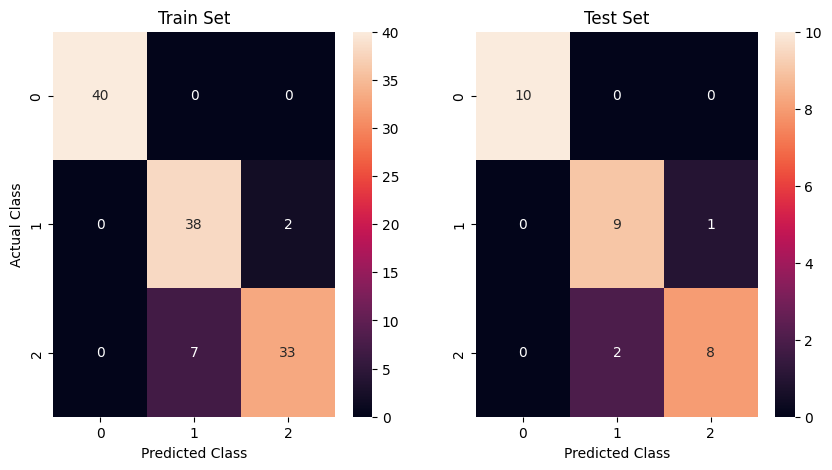

In [164]:
model_perf(extra_clf, X_train, y_train, X_test, y_test)

In [123]:
# with open("extra_clf.pkl", mode = 'wb') as file:
#   pickle.dump(extra_clf, file)

# Using AdaBoost

In [124]:
# Importing the model from first run
with open("/content/drive/MyDrive/CipherByte/IRIS/ada_clf.pkl", mode = 'rb') as file:
  ada_clf = pickle.load(file)

In [125]:
# from sklearn.ensemble import AdaBoostClassifier
# ada_clf = AdaBoostClassifier(estimator = rnd_clf)
# params_grid_ada = {"learning_rate": [0.01, 0.1, 1, 10]}
# grid_ada = GridSearchCV(ada_clf, params_grid_ada, cv = 3)
# grid_ada.fit(X_train, y_train)
# grid_ada.best_params_

In [126]:
# ada_clf = grid_ada.best_estimator_
# ada_clf.bootstrap = True
# ada_clf.oob_score = True
# ada_clf.fit(X_train, y_train)

In [127]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.9

In [128]:
cross_val_score(ada_clf, X_reduced, y, cv=3, n_jobs = -1)

array([0.94, 0.94, 0.96])

In [129]:
# with open("ada_clf.pkl", mode = 'wb') as file:
#   pickle.dump(ada_clf, file)

# Using Gradient Boosting

In [130]:
# Importing the model from previous run
with open("/content/drive/MyDrive/CipherByte/IRIS/gbc_clf.pkl", mode = 'rb') as file:
  gbc_clf = pickle.load(file)

In [131]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbc_clf = GradientBoostingClassifier()
# params_grid_gbc = {"n_estimators": np.arange(500,2500,500),
#                    "learning_rate": [0.01, 0.1, 1, 10],
#                    "max_depth": range(1,5)}
# grid_gbc = GridSearchCV(gbc_clf, params_grid_gbc, cv = 3)
# grid_gbc.fit(X_train,y_train)
# grid_gbc.best_params_

In [132]:
# gbc_clf = grid_gbc.best_estimator_
# gbc_clf.fit(X_train,y_train)
# accuracy_score(gbc_clf.predict(X_test), y_test)

In [133]:
cross_val_score(gbc_clf, X_reduced, y, cv=3, n_jobs = -1)

array([0.96, 0.88, 0.98])

In [134]:
# with open("gbc_clf.pkl", mode ="wb") as file:
#   pickle.dump(gbc_clf, file)

# Using XGBoost

In [135]:
# load the model from previous run
with open("/content/drive/MyDrive/CipherByte/IRIS/xgb_clf.pkl", mode = 'rb') as file:
  xgb_clf = pickle.load(file)

In [136]:
# import xgboost
# xgb_clf = xgboost.XGBClassifier()

# params_grid_xgb = {"n_estimators": np.arange(500,2500,500),
#                    "learning_rate": [0.01, 0.1, 1, 10],
#                    "max_depth": range(1,5)}
# grid_xgb = GridSearchCV(xgb_clf, params_grid_xgb, cv = 3)
# grid_xgb.fit(X_train, y_train)
# grid_xgb.best_params_

In [137]:
# xgb_clf = grid_xgb.best_estimator_
# xgb_clf.fit(X_train, y_train)

In [138]:
# cross_val_score(xgb_clf, X_train, y_train, cv = 3)

In [139]:
# # Save the model for future use
# with open("/content/drive/MyDrive/CipherByte/IRIS/xgb_clf.pkl", mode = 'wb') as file:
#   pickle.dump(xgb_clf, file)

In [140]:
accuracy_score(y_test, xgb_clf.predict(X_test))

0.9